<a href="https://colab.research.google.com/github/SarveshPatil99/Adversarial-Robustness-Enhancement/blob/main/TML_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install image-classifiers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [2]:
# StyleGAN3 - 10000
!gdown https://drive.google.com/uc?id=18MZZwgKjTGlB2Y4Esw_lRIvbpOaANbnh
!unzip -q original_dataset_stylegan3_10000.zip

Downloading...
From: https://drive.google.com/uc?id=18MZZwgKjTGlB2Y4Esw_lRIvbpOaANbnh
To: /content/original_dataset_stylegan3_10000.zip
100% 2.12G/2.12G [00:20<00:00, 104MB/s]


In [ ]:
# StyleGAN2 - 5000
!gdown https://drive.google.com/uc?id=1ZBxnHMArN2-HAdViUFKarKxuXVk4sREk
!unzip original_dataset_stylegan2_5000.zip

Downloading...
From: https://drive.google.com/uc?id=1ZBxnHMArN2-HAdViUFKarKxuXVk4sREk
To: /content/original_dataset_stylegan2_5000.zip
100% 1.08G/1.08G [00:08<00:00, 121MB/s]


In [ ]:
# StyleGAN3 - 5000
!gdown https://drive.google.com/uc?id=1-BTtMGzH8925FtIu20KbkfmmSz3LNTer
!unzip original_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1-BTtMGzH8925FtIu20KbkfmmSz3LNTer
To: /content/original_dataset.zip
100% 1.06G/1.06G [00:06<00:00, 171MB/s]


In [4]:
import tensorflow as tf
import numpy as np
import pathlib
import os
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, ReLU, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import pickle
from matplotlib import pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [29]:
dataset_name = 'original'
train_dir = pathlib.Path(f'{dataset_name}/train')
val_dir = pathlib.Path(f'{dataset_name}/val')
test_dir = pathlib.Path(f'{dataset_name}/test')
train_len = len(list(train_dir.glob('*/*.png')))
val_len = len(list(val_dir.glob('*/*.png')))
classes = np.array(os.listdir(f'{dataset_name}/train'))
class_dict = dict(zip(classes,range(len(classes))))
print(train_len, val_len)
print(class_dict)

16000 2000
{'real': 0, 'fake': 1}


In [20]:
img_height = 256
img_width = 256
batch_size = 16

noise_params = {
    'gaussian': {'stddev': 0.05},
    'saltpepper': {'pepper_thresh': 0.025,'salt_thresh': 0.025},
    'speckle': {'stddev': 0.05},
    'poisson': {'lambda': 0.5}
}

# Noise functions

def noise_gaussian(image):
  stddev = noise_params['gaussian']['stddev']
  noise = tf.random.normal(shape=tf.shape(image), mean=0, stddev=stddev)
  image = image + noise
  image = tf.clip_by_value(image, 0, 1)
  return image

def noise_poisson(image):
  # lam = noise_params['poisson']['lambda']
  # noise = tf.random.poisson(shape=tf.shape(image), lam=lam)
  # image = image + noise
  # image = tf.clip_by_value(image, 0, 1)
  return image

def noise_saltpepper(image):
  pepper_thresh = noise_params['saltpepper']['pepper_thresh']
  salt_thresh = noise_params['saltpepper']['salt_thresh']

  noise_map = tf.random.uniform((256,256))
  pepper_map = tf.cast(noise_map < pepper_thresh, tf.float32)
  pepper_map = tf.stack([pepper_map]*3,-1)
  salt_map = tf.cast(noise_map > (1-salt_thresh), tf.float32)
  salt_map = tf.stack([salt_map]*3,-1)

  image = image - 2*pepper_map
  image = image + 2*salt_map
  image = tf.clip_by_value(image, 0, 1)

  return image

def noise_speckle(image):
  stddev = noise_params['gaussian']['stddev']
  noise = tf.random.normal(shape=tf.shape(image), mean=0, stddev=stddev)
  image = image + image*noise
  image = tf.clip_by_value(image, 0, 1)
  return image

noise_func = None

def create_label(image_path):
  class_name = tf.strings.split(image_path,'/')[-2]
  return tf.cast(classes == class_name,tf.float32)

def load(image_path):

  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image) / 255
  # image = tf.image.resize(image, [img_height, img_width])

  if noise_func:
    image = noise_func(image)

  label = create_label(image_path)

  return image, label

train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)
train_ds = train_ds.shuffle(len(train_ds), reshuffle_each_iteration=False)
train_ds = train_ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.cache('tmp')
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds_length = len(train_ds)

val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'), shuffle=False)
val_ds = val_ds.shuffle(len(val_ds), reshuffle_each_iteration=False)
val_ds = val_ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.batch(batch_size)
val_ds_length = len(val_ds)

print(f'train_ds_length: {train_ds_length}, val_ds_length: {val_ds_length}')

train_ds_length: 1000, val_ds_length: 125


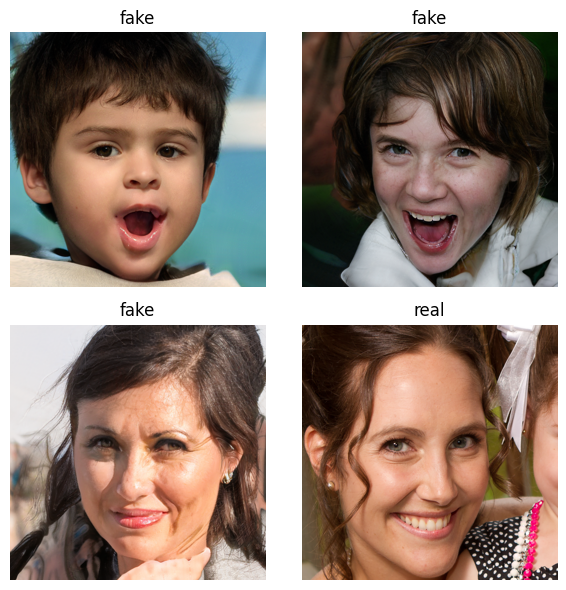

In [12]:
for x, y in train_ds.take(1):
  pass
# plt.figure(figsize=(32,10))
plt.figure(figsize=(6,6))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(x[i])
  plt.axis('off')
  plt.title(classes[tf.argmax(y[i])])
plt.tight_layout()

In [25]:
def conv_bn_relu(filters,x,idx,label):
    x = SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform',name=f'conv_{idx}{label}')(x)
    x = BatchNormalization(name=f'bn_{idx}{label}')(x)
    x = ReLU(name=f'relu_{idx}{label}')(x)
    # x = Dropout(rate=0.1,name=f'dropout_{idx}{label}')(x)
    return x

def create_model(input_shape = (256, 256, 3)):
  input_layer = Input(input_shape,name='input')
  n_filters = 8
  x = input_layer
  for i in range(5):
    x = conv_bn_relu(n_filters,x,i,'a')
    x = conv_bn_relu(n_filters,x,i,'b')
    x = MaxPooling2D(name=f'maxpool_{i}')(x)
    n_filters = int(n_filters*2)
  # x = Flatten(name='flatten')(x)
  x = GlobalAveragePooling2D(name='global_pool')(x)
  # x = Dense(32,activation='relu',name='dense_0')(x)
  # x = Dropout(rate=0.2,name=f'dropout_dense')(x)
  x = Dense(2,activation='softmax',name='dense_0', dtype = 'float32')(x)

  model = Model(inputs = [input_layer], outputs = [x])

  return model

In [26]:
model = create_model()
model.count_params()

38805

In [ ]:
lr = 1e-3
epochs = 50
rLR_patience = 5
es_patience = 10
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model_name = 'baseline'
model_filename = f'{model_name}_lr={lr:.0e}'
model_path = f'saved/models/{model_filename}.h5'
history_path = f'saved/histories/{model_filename}.pkl'
pathlib.Path('saved/models').mkdir(exist_ok=True,parents=True)
pathlib.Path('saved/histories').mkdir(exist_ok=True,parents=True)

checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode = 'max', factor=1/np.sqrt(10), patience = rLR_patience, min_lr=1e-6, verbose = 1)
earlystopper = EarlyStopping(monitor='val_accuracy', mode = 'max', patience = es_patience, verbose=1)
callbacks = [checkpoint, reduce_lr, earlystopper]

#model = create_model()
optimizer = RMSprop(learning_rate = lr)
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
hist = model.fit(train_ds, epochs = epochs, validation_data = val_ds, callbacks = callbacks, verbose = 1)
with open(history_path, 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

In [ ]:
model.load_weights(model_path)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [30]:
test_ds = tf.data.Dataset.list_files(str(test_dir/'*/*'), shuffle=False)
test_ds = test_ds.shuffle(len(test_ds), reshuffle_each_iteration=False)
test_ds = test_ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.batch(batch_size)
test_ds_length = len(test_ds)

print(f'test_ds_length: {test_ds_length}')

test_ds_length: 125


In [32]:
model.evaluate(test_ds)

125/125 [==============================] - 8s 66ms/step - loss: 0.7293 - accuracy: 0.8150


[0.7292691469192505, 0.8149999976158142]